# Empirical Analysis

* This notebook contains the codes to provide the data and analysis in Section 5.
* You can view and download this notebook at my [github repo](https://github.com/okuchap/DAA_Lucas). (https://github.com/okuchap/DAA_Lucas)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import time
from datetime import datetime
from scipy.optimize import minimize

# used for greedy optimization
from sklearn.utils.extmath import cartesian

#np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
# plt.style.use("ggplot")
# plt.rcParams["font.size"] = 13
mpl.rcParams["font.family"] = 'Osaka'

## Overview

* Focus on the last quarter of 2018 (October 2018 to December 2018)

* Assume that the hash supply is linear in reward:

$$
H(t) = \alpha + \beta R(t)
$$

The estimates we obtained are

$$
\hat{\alpha} = 23.60, \hat{\beta} = 9.02, \quad
\sigma(\hat{\alpha}) = 2.25, \sigma(\hat{\beta}) = 0.99
$$

## Method

### Data Cleaning

* Compute the block time using timestamps.

* Basically, the time required to generate the $i$-th block is $\Delta_i := t_i - t_{i-1}$.
    - However, sometimes $\Delta_i$ becomes negative due to inaccuracy.

* We conduct our analysis as follows:

Let $\{t_i\}_i$ be the times recorded in timestamps. For each $i$, let

$$
k^* = \min_{k \geq 1} \{k \colon t_i < t_{i+k}\}
$$
and linearly interpolate $t_0, t_1, \dots, t_k$ by the function `adjust_BGT`.

In [2]:
def adjust_unixtime(raw_times):
    '''
    adjust block generation time.
    Conduct linear interpolation if the order of time stamps are reversed.
    
    Parameters
    ----------
    raw_times:
        pandas Series containing raw time stamps(unixtime)
        The index should starts at zero.
        
    Returns
    -------
    times:
        Adjusted time stamps.
    '''
    times = raw_times.copy()
    for i in range(times.shape[0] - 1):
        if times[i+1] - times[i] < 0:
            count = 1
            diff = -1
            while diff < 0:
                count += 1
                diff = times[i+count] - times[i]
            delta = times[i+count] - times[i]
            for j in range(count-1):
                times[i+j+1] = times[i] + (delta/count)*(j+1)

    return times

### Estimate the hash supply function in BTC system

$$
h(R) = \alpha + \beta R
$$

* The loglikelihood is

$$
\log \mathcal{L}(\alpha,\beta) = \sum_{t} \left\{ \log D(t) + \log(\alpha + \beta R(t)) -D(t)(\alpha + \beta R(t))B(t) \right\}
\propto
\sum_{t} \left\{\log(\alpha + \beta R(t)) -D(t)(\alpha + \beta R(t))B(t) \right\}
$$


* Focus on October 2018 to December 2018. Here, we include the transaction fee in expected reward.

* The file `BTCdata_2.csv` contains the raw data.

In [3]:
path = '../data/BTCdata_2.csv'
df_BTC = pd.read_csv(path, header=0)
df_BTC = df_BTC.rename(columns={'unixtime_precise': 'unixtime'})
df_BTC = df_BTC.loc[: ,['height', 'unixtime', 'probability of success /Eh', 'expected return (USD/Eh)']]
df_BTC['time'] = pd.to_datetime(df_BTC['unixtime'].astype(int), unit='s')
df_BTC = df_BTC.sort_values(by='height', ascending=True)
df_BTC.head()

,height,unixtime,probability of success /Eh,expected return (USD/Eh),time
0,450001,1485382343,0.000593,6.935004,2017-01-25 22:12:23
1,450002,1485383957,0.000593,7.424957,2017-01-25 22:39:17
2,450003,1485384299,0.000593,7.184180,2017-01-25 22:44:59
3,450004,1485384419,0.000593,7.025926,2017-01-25 22:46:59
4,450005,1485384847,0.000593,7.086069,2017-01-25 22:54:07


In [4]:
df_BTC_2018OctDec = df_BTC[(df_BTC['time'] >= datetime(2018,9,30)) & (df_BTC['time'] <= datetime(2019,1,1))]
df_BTC_2018OctDec = df_BTC_2018OctDec.reset_index(drop=True)
BTC_times = df_BTC_2018OctDec['unixtime']
df_BTC_2018OctDec['adj_time'] = adjust_unixtime(BTC_times)
df_BTC_2018OctDec['adj_block_gen_time(min)'] = df_BTC_2018OctDec['adj_time'].diff()/60
df_BTC_2018OctDec = df_BTC_2018OctDec[df_BTC_2018OctDec['time'] >= datetime(2018,10,1)]
df_BTC_2018OctDec.head()

,height,unixtime,probability of success /Eh,expected return (USD/Eh),time,adj_time,adj_block_gen_time(min)
163,543835,1538352272,0.000033,2.720620,2018-10-01 00:04:32,1538352272,18.633333
164,543836,1538352799,0.000033,2.711797,2018-10-01 00:13:19,1538352799,8.783333
165,543837,1538352841,0.000033,2.694189,2018-10-01 00:14:01,1538352841,0.700000
166,543838,1538352940,0.000033,2.697526,2018-10-01 00:15:40,1538352940,1.650000
167,543839,1538353463,0.000033,2.714195,2018-10-01 00:24:23,1538353463,8.716667


In [5]:
df = df_BTC_2018OctDec.loc[:, ['adj_block_gen_time(min)', 'probability of success /Eh', 'expected return (USD/Eh)']]
df['adj_block_gen_time(sec)'] = df['adj_block_gen_time(min)']*60
df.head()

,adj_block_gen_time(min),probability of success /Eh,expected return (USD/Eh),adj_block_gen_time(sec)
163,18.633333,0.000033,2.720620,1118.0
164,8.783333,0.000033,2.711797,527.0
165,0.700000,0.000033,2.694189,42.0
166,1.650000,0.000033,2.697526,99.0
167,8.716667,0.000033,2.714195,523.0


### Optimization via Scipy

In [7]:
block_times = df.loc[:, 'adj_block_gen_time(sec)'].values
block_gen_rates = df.loc[:, 'probability of success /Eh'].values
exp_rewards = df.loc[:, 'expected return (USD/Eh)'].values

def log_likelihood(params):
    '''
    params = [a, b]
    '''    
    a = params[0]
    b = params[1]
    
    temp = np.log(a + b * exp_rewards) \
        - (block_gen_rates * (a + b * exp_rewards) * block_times)
    ll = np.sum(temp)
    
    return -ll

In [8]:
x0 = np.array([24.0, 9.0])

result = minimize(fun = log_likelihood,
                  x0=x0, 
                  method="L-BFGS-B")
print(result)

      fun: -35200.9856368449
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0007276, -0.0007276])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 10
     njev: 12
   status: 0
  success: True
        x: array([23.58815554,  9.02489233])


Therefore, the MLE is
$$
\hat{\alpha} = 23.59, \hat{\beta} = 9.02.
$$

## Estimation via log-scaled variables

* Assume the following linear model and estimate parameters $\alpha, \beta$ via MLE:
$$
\log H(t) = \alpha + \beta \log R(t),
$$
which is equivalent to
$$
H(t) = \mathrm e^{\alpha} R(t)^{\beta}.
$$
* The likelihood function is
$$
\mathcal{L} = \prod_t W(t) \left(
\mathrm e^{\alpha} R(t)^{\beta}
\right)
\exp \left(-W(t) B(t) \mathrm e^{\alpha} R(t)^{\beta}\right).
$$
* The log-likelihood function is
$$
\log \mathcal{L} \propto \sum_t \left[\alpha + \beta \log R(t)  - W(t) B(t) \mathrm e^{\alpha} R(t)^{\beta} \right].
$$

We obtained the MLE such that
$$
\hat \alpha = 3.42, \ \hat \beta = 0.45.
$$

### Computation

In [10]:
def log_likelihood_2(params):
    '''
    params = [a, b]
    '''    
    a = params[0]
    b = params[1]
    
    temp = a + b*np.log(exp_rewards) - block_gen_rates*block_times*np.exp(a)*np.power(exp_rewards, b)
    ll = np.sum(temp)
    
    return -ll

In [11]:
x0 = np.array([3.0, 0.5])

result = minimize(fun = log_likelihood_2,
                  x0=x0, 
                  bounds = ((0,np.inf),(0.01,np.inf)),
                  method="L-BFGS-B")
print(result)

      fun: -35200.493577691355
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00800355, 0.00582077])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 39
      nit: 11
     njev: 13
   status: 0
  success: True
        x: array([3.41878738, 0.45145085])


Therefore, the MLE is
$$
\hat \alpha = 3.42, \ \hat \beta = 0.45.
$$

### Plot

In [12]:
@np.vectorize
def log_hash_supply(log_x):
    return np.log(55) - np.log(1 + np.exp(4.5)*np.exp(-3*np.exp(log_x)))

In [14]:
x = np.linspace(0.01, 3.0, 300)
log_x = np.log(x)
alpha = 3.42
beta = 0.45
y = log_hash_supply(log_x)
y_est = alpha + beta * log_x
flag = log_x > np.log(1.58)
log_x_truncated = log_x[flag]
y_est_truncated = y_est[flag]

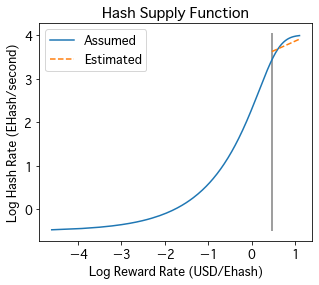

In [16]:
plt.rcParams["font.size"] = 12

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(1,1,1, aspect='equal', title='Hash Supply Function')
ax.plot(log_x, y, label='Assumed')
ax.plot(log_x_truncated, y_est_truncated, label='Estimated', linestyle='--')
ax.vlines(np.log(1.58), ymin=-0.5, ymax=4.05, linestyles='-', colors='gray')

ax.set_xlabel('Log Reward Rate (USD/Ehash)')
ax.set_ylabel('Log Hash Rate (EHash/second)')

ax.legend()
plt.show()

### Variance-Covariance Matrix

The Fisher information matrix is
$$
I(\hat \alpha, \hat \beta) = 
\begin{bmatrix}
\sum_t 1 & \sum_t \log R(t) \\
\sum_t \log R(t) & \sum_t (\log R(t))^2
\end{bmatrix}.
$$
Thus the variance-covariance matrix is
$$
V(\hat \alpha, \hat \beta) = (I (\hat \alpha, \hat \beta))^{-1}
=
\begin{bmatrix}
0.00223838 & -0.00263739 \\
-0.00263739 & 0.00322153
\end{bmatrix}.
$$

In [8]:
I = np.zeros((2,2))

In [9]:
df.head()

,adj_block_gen_time(min),probability of success /Eh,expected return (USD/Eh),adj_block_gen_time(sec)
163,18.633333,0.000033,2.720620,1118.0
164,8.783333,0.000033,2.711797,527.0
165,0.700000,0.000033,2.694189,42.0
166,1.650000,0.000033,2.697526,99.0
167,8.716667,0.000033,2.714195,523.0


In [13]:
logR = np.log(df['expected return (USD/Eh)'].values)

In [15]:
logR

array([1.00085961, 0.9976114 , 0.9910974 , ..., 0.65084736, 0.65284063,
       0.65152842])

In [16]:
logR**2

array([1.00171996, 0.9952285 , 0.98227406, ..., 0.42360228, 0.42620089,
       0.42448928])

In [20]:
T = df.shape[0]
I[0,0] = T
I[0,1] = np.sum(logR)
I[1,0] = np.sum(logR)
I[1,1] = np.sum(logR**2)
I

array([[12624.        , 10334.96759002],
       [10334.96759002,  8771.40286181]])

In [21]:
V = np.linalg.inv(I)
V

array([[ 0.00223838, -0.00263739],
       [-0.00263739,  0.00322153]])